# <font color='navy'> L2 to L3 Multihit Walkthrough

* Modifying old walkthrough to update.

* The L3 should have the CUD format.
* The CUD will be modified to include the position calibration and multihit.

**Right now we are focused on multihit.**

>**<font color='green'>Functions**   
>**<font color='red'>Plots**    

# <font color='navy'>Read, select and convert.

In [4]:
%matplotlib inline
import os
import math
import h5py

import numpy as np
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
#import tracker_pipeline
#import tracker_pipeline.conv_l2tol3_new as mh
from labellines import labelLine, labelLines

In [5]:
np.set_printoptions(suppress=True)

In [6]:
fdata_dict ={
    'B_r1'   : '/Users/swasti/code/test_temp/multi_hit/Beam_r1_5MeV/2022-04-25_1650913642_5MeVBeam_1hour_Tracker_L2.h5',
    'PB_r85' : '/Users/swasti/code/test_temp/multi_hit/PreBeam_r85_Cs137/1649092713_Apr4_Cs137_Mode7C_L2.h5',
    'S_20mev_ns' : '/Users/swasti/code/test_temp/multi_hit/sim_20meV_nosmear/TKR_20MeVBeam-100000Trig.inc1.id1_sim.L2.h5',
    'S_2mev_sim':'/Users/swasti/code/test_temp/multi_hit/sim_2meV/Cosima.sim.h5',
    'B_r22'  : '/Users/swasti/code/beamtest/run22-15MeV/2022-04-28_1022_1651155763_15MeVBeam_1hour_run22_tracker_L2.h5',
    'B_r22_l2'   : '/Users/swasti/code/beamtest/run22-15MeV/2022-04-28_1022_1651155763_15MeVBeam_1hour_run22_tracker_L2.h5',
    
}


In [7]:
fname = fdata_dict['B_r22_l2']
#fname = fdata_dict['B_r1']
fpath = fname[0:fname.rfind('/')+1]
fname, fpath

('/Users/swasti/code/beamtest/run22-15MeV/2022-04-28_1022_1651155763_15MeVBeam_1hour_run22_tracker_L2.h5',
 '/Users/swasti/code/beamtest/run22-15MeV/')

In [8]:
file = h5py.File(fname,'r')

# outfile = f"3.h5"
# outfile

## <font color='blue'>Check attributes to verify calibration file

In [9]:
file.attrs.keys()

<KeysViewHDF5 ['compair_daq_git_branch', 'compair_daq_git_hash', 'ecalib_file', 'l1tol2_ecal_func_version', 'recording_start_time', 'recording_stop_time']>

In [10]:
file.attrs['ecalib_file']

'TKR_EnergyCalibrationCoefficients_20220420.dat'

In [11]:
file.keys()

<KeysViewHDF5 ['Calibration', 'layer00', 'layer01', 'layer02', 'layer03', 'layer04']>

In [12]:
calflags = file['Calibration/cflag'][...]
calflags.shape

(10, 2, 192)

# <font color='navy'>Basic Checks on dataset

In [13]:
file['layer00/data'].keys()

<KeysViewHDF5 ['asic00', 'asic01', 'asic02', 'asic03', 'asic04', 'asic05', 'asic06', 'asic07', 'asic08', 'asic09', 'asic10', 'asic11', 'event_count', 'event_id', 'gps_pps_count', 'layer_number', 'live_time', 'packet_size', 'packet_tail', 'packet_type', 'pl_data_header', 'running_time', 'sync_index', 'system_time', 'tbd', 'time_since_last_pps_pulse', 'triggering_condition', 'vata_ro_ena']>

In [14]:
if f'layer00/data/sync_index' in file:
    print("YES")

YES


In [15]:
print(file['layer00/data/event_id'],file['layer01/data/event_id'])

<HDF5 dataset "event_id": shape (1000533,), type "<u4"> <HDF5 dataset "event_id": shape (999887,), type "<u4">


print(file['layer00/data/system_time'],file['layer01/data/event_count'])

In [16]:
file['layer00/vdata'].keys()

<KeysViewHDF5 ['channel_cm_sub', 'channel_data', 'nrg', 'sig_arr']>

In [17]:
file['layer00/vdata/nrg']

<HDF5 dataset "nrg": shape (1000533, 2, 192), type "<f8">

In [18]:
file['layer00/vdata/channel_cm_sub']

<HDF5 dataset "channel_cm_sub": shape (1000533, 2, 192), type "<i4">

# <font color='navy'> Extract L3 datasets from L2

> Follow l2 to l3 process. 
Try to find a place to interject the added coding scripts

In [19]:
layer_list = [f"layer{n:02d}" for n in range(10)]
for i in range(10):
    if layer_list[i] in file.keys():
        print(f"Layer {i} Present")

Layer 0 Present
Layer 1 Present
Layer 2 Present
Layer 3 Present
Layer 4 Present


## <font color='blue'>Sanity Checks

In [20]:
nsync = [file[f"{layer}/data/sync_index"].size for layer in layer_list if layer in file]
max_size = nsync[0]
max_size

968960

<font color='blue'> **making sure the syncindex is corrrect for all layers**
   

In [21]:
assert all(np.array(nsync) == max_size)

In [22]:
max_size = max_size-1 #We are skipping the EVENTID=0 or sync_index=0

## <font color='blue'> Event ID and Event Time

In [23]:
layer_list = ['layer00','layer01','layer02','layer03','layer04','layer05','layer06','layer07','layer08','layer09']

* <font color='blue'>Event Id and Event Time (shape = eventid)
* <font color='blue'>This is same for all layers due to sync_index
* <font color='blue'> We only need 1 layer but we are looping in case layer 0 is not plugged in the layer stack

In [24]:
for i in range(10):
    if layer_list[i] in file.keys():
        sync_index = file[f"{layer_list[i]}/data/sync_index"][...]
        evtdata = file[f"{layer_list[i]}/data/event_id"][...]
        event_id = evtdata[sync_index[1:]]
        

        evttime = file[f"{layer_list[i]}/data/system_time"][...]
        event_time = evttime[sync_index[1:]]

        print(f" Layer :{i} done")
        

 Layer :0 done
 Layer :1 done
 Layer :2 done
 Layer :3 done
 Layer :4 done


In [25]:
len(event_time)

968959

In [26]:
max_size

968959

## <font color='blue'> Pulse Height

In [27]:
pulse_height = np.zeros((max_size,10,2,192))
print(pulse_height.shape)
for i in range(10):
    if layer_list[i] in file.keys():
        data = file[f"{layer_list[i]}/vdata/channel_cm_sub"][...]
        sync_index = file[f"{layer_list[i]}/data/sync_index"][...]
        sync_index = np.array(sync_index)
        print(len(sync_index[1:]))
        print(f"Layer:{i} , Id Len:{len(sync_index)}")

        pulse_height[:, i, :, :] = data[sync_index[1:], :, :]

(968959, 10, 2, 192)
968959
Layer:0 , Id Len:968960
968959
Layer:1 , Id Len:968960
968959
Layer:2 , Id Len:968960
968959
Layer:3 , Id Len:968960
968959
Layer:4 , Id Len:968960


In [28]:
file['layer00/vdata'].keys()

<KeysViewHDF5 ['channel_cm_sub', 'channel_data', 'nrg', 'sig_arr']>

## <font color='gray'> Energy (Previous Algorithm)
> * The data was is evtid, x, y, z, energy format.
> * It got extracted to 10, 2, 192 format. 

# <font color='navy'>Multi-Hit process walkthrough.

> We are selecting energy from array event wise.

currently the nrg is in (nevt, side, det) format.
we want a n_evt, x , y, z, energy..

**Current Steps**      

In [29]:
file['layer00/vdata/nrg']

<HDF5 dataset "nrg": shape (1000533, 2, 192), type "<f8">

In [30]:
t=  file['layer00/vdata/nrg'].dtype

## Code, functions, etc

### <font color='darkgreen'> Initial Definition

In [31]:
NRG_PER = 60 # percentage to check energy
NLAYERS = 5
#---- Position Constansts ----
TKR_STRIP_PITCH     = 0.051                             # [cm] 510 microns
TKR_WIDTH           = 192 * TKR_STRIP_PITCH             # [cm] 192 strips of constant pitch
TKR_EDGE            = TKR_WIDTH/2.0                     # DSSD is centered at 0, thus the edges are equivalent to half of the width
TKR_STRIP_CENTROID  = TKR_EDGE - (TKR_STRIP_PITCH)/2.0  # Gives the center of strip 191

TRK_LAYER_THICKNESS = 0.05 

TKR_LAYER_SPACING   = 1.9      
# [cm] z spacing between layers
TKR_TOP_LAYER       = (TRK_LAYER_THICKNESS/2.0) + (NLAYERS - 1) * TKR_LAYER_SPACING # [cm] Global z position of layer 0 of the TKR 

XPOS_TBL = np.zeros((192))
YPOS_TBL = np.zeros((192))
ZPOS_TBL = np.zeros((NLAYERS))

for detector_number in range(NLAYERS):
    global ZPOS_TBL
    ZPOS_TBL[detector_number] = float(-detector_number * TKR_LAYER_SPACING + TKR_TOP_LAYER)

for strip_number in range(192):
    XPOS_TBL[strip_number] = float(strip_number * TKR_STRIP_PITCH - TKR_STRIP_CENTROID)
    YPOS_TBL[strip_number] = float(-strip_number * TKR_STRIP_PITCH + TKR_STRIP_CENTROID)


def get_xyz(xloc, yloc, layer):
    xpos = XPOS_TBL[xloc]
    ypos = YPOS_TBL[yloc]
    zpos = ZPOS_TBL[layer]

    return (xpos, ypos, zpos)

In [32]:
def TKR_pinpoint(xpos, ypos, zpos):

    xstrip = round((float(xpos)+TKR_STRIP_CENTROID)/TKR_STRIP_PITCH)
    ystrip = round(-(float(ypos)-TKR_STRIP_CENTROID)/TKR_STRIP_PITCH)
    zlayer = round(abs((float(zpos)-TKR_TOP_LAYER)/TKR_LAYER_SPACING))
    # print('X-strip # ' + str(xstrip) + '; Y-strip # ' + str(ystrip) + '; Z-layer # ' + str(zlayer))
    return xstrip, ystrip, zlayer

In [33]:
#TKR_pinpoint(-4.1565,1.5555,0.025)
TKR_pinpoint(-0.2805,   -0.7395,    5.725)

(90, 110, 1)

In [34]:
XPOS_TBL[90]

-0.28049999999999997

In [35]:
for i in range(NLAYERS):
    print(i, ZPOS_TBL[i])

0 7.625
1 5.725
2 3.825
3 1.9250000000000007
4 0.025000000000000355


In [36]:
global NLAYERS
NLAYERS = 6
global ZPOS_TBL
ZPOS_TBL = np.zeros((NLAYERS))
for detector_number in range(NLAYERS):
    global ZPOS_TBL
    ZPOS_TBL[detector_number] = float(-detector_number * TKR_LAYER_SPACING + TKR_TOP_LAYER)

In [37]:

print(NLAYERS)
for i in range(NLAYERS):
    print(i, ZPOS_TBL[i])

6
0 7.625
1 5.725
2 3.825
3 1.9250000000000007
4 0.025000000000000355
5 -1.875


In [38]:
print("X")
for i in range(192):

    xpos = XPOS_TBL[i]
    strip = round((float(xpos)+TKR_STRIP_CENTROID)/TKR_STRIP_PITCH)
    if strip !=i:
        print(f"{i}: Wrong conversion")
print("Y")
for i in range(192):

    ypos = YPOS_TBL[i]
    strip = round(-(float(ypos)-TKR_STRIP_CENTROID)/TKR_STRIP_PITCH)
    if strip !=i:
        print(f"{i}: Wrong conversion")

X
Y


In [39]:
abs(XPOS_TBL[0]-XPOS_TBL[1])

0.051000000000000156

### Test

### <font color='darkgreen'> Utiltiy functions

In [40]:
neighbor_length = 1 # How separate are the neighbors.
def chk_neighbor(loc1, loc2):
    # Checks if the two locations are neighbors
    neigh_flag = False
    if abs(loc1-loc2) == neighbor_length:
        neigh_flag = True
    return neigh_flag


def chk_common_strip(sin_hit, dbl_hit_1, dbl_hit_2 ):
    # check if the sum of dbl_hits is close to sin_hit
    if (chk_nrg_onehit(sin_hit,dbl_hit_1+dbl_hit_2)) is not None: # we dont care x and y at this phase.
        return True
    else:
        return False

def avg_xpos(x1,x2):
    xpos1 = XPOS_TBL[x1]
    xpos2 = XPOS_TBL[x2]
    return((xpos1+xpos2)/2.0)
    

def avg_ypos(y1,y2):
    ypos1 = YPOS_TBL[y1]
    ypos2 = YPOS_TBL[y2]
    return((ypos1+ypos2)/2.0)
    


### <font color='darkgreen'> One Hit Code Block

In [41]:
def chk_nrg_onehit(xnrg, ynrg):
    # this checks the x and y nrg to average or throw.
    avg_flag = False
    #delta = 0.0
    xnrg = float(xnrg)
    ynrg = float(ynrg)
    xnrg_list.append(xnrg)
    ynrg_list.append(ynrg)
    
    nrg_diff = abs(ynrg-xnrg)
    nrg_add  = ynrg+xnrg
    
    delta_list.append(nrg_diff/nrg_add)
    if (nrg_diff/nrg_add) < (NRG_PER/100.0):
        avg_flag = True

    if (avg_flag):
        return ((xnrg+ynrg)/2.0)
    else:
        return None
    
def one_hit_fnc(evt):
    #This is for the 1-1 event. 
    global cnt_1a
    xloc = np.where(evt[0,:] > 0)[0]
    yloc = np.where(evt[1,:] > 0)[0]

    t_xloc1 = xloc[0]
    t_yloc1 = yloc[0]
            
    t_xnrg1 = evt[0,xloc[0]]
    t_ynrg1 = evt[1,yloc[0]]

    avg_nrg = (chk_nrg_onehit(t_xnrg1,t_ynrg1))
    if (avg_nrg) is not None:
        cnt_1a += 1
        xpos = XPOS_TBL[t_xloc1]
        ypos = YPOS_TBL[t_yloc1]
        zpos = ZPOS_TBL[layer]
        
        qflag = 1

        return [[xpos, ypos, zpos, avg_nrg, qflag]]
    else:
        return None

### <font color='darkgreen'> Two Hit functions

#### A2B1

In [42]:
def two_hit_A2B1(xloc, yloc, xpos, ypos, xnrg, ynrg, layer,skip_x=False):
    global cnt_2b_1
    global cnt_2b_1a
    
    global cnt_2b_2
    global cnt_2b_3
    global cnt_2b_3a
    
    # X and Z are common for all options.
    zpos    = ZPOS_TBL[layer]
    ypos = ypos[0]
    qflag = 1
    #-- Check Nrg--
    
    if skip_x is False:
        if (chk_neighbor(xloc[0],xloc[1])): 
            cnt_2b_1 += 1

            new_nrg = xnrg[0] + xnrg[1]
            xpos    = (xpos[0]+xpos[1])/2.0 

            new_avg_nrg= chk_nrg_onehit( new_nrg,ynrg[0])

            if (new_avg_nrg) is not None:
    #             cnt_2a_1a += 1
                return [[xpos, ypos, zpos, new_avg_nrg, qflag]]
            else:
                return None
    
    #-- Check Common Nrg--
    elif chk_common_strip(ynrg[0],xnrg[0],xnrg[1]):
        cnt_2b_2+= 1
            
        xnrg_0 = xnrg[0]
        xnrg_1 = xnrg[1]
        ynrg = ynrg[0]
        
        new_avg_nrg= chk_nrg_onehit(xnrg_0+xnrg_1, ynrg)
        if new_avg_nrg is not None:

            ynrg_0 = ynrg * (xnrg_0/ (xnrg_0+xnrg_1))
            ynrg_1 = ynrg * (xnrg_1 / (xnrg_0 + xnrg_1))

            nrg0 = (xnrg_0+ynrg_0)/2.0
            nrg1 = (xnrg_1+ynrg_1)/2.0

            xpos0 = xpos[0]
            xpos1 = xpos[1]

            return [[xpos0,ypos,zpos,nrg0,qflag],[xpos1,ypos,zpos,nrg1,qflag]]

    #-- Try to find closest Nrg and Check Valid-- (Salvage)
    else:
        cnt_2b_3+= 1
        # Salvaging Event
        xnrg1 = xnrg[0]
        xnrg2 = xnrg[1]
        ynrg = ynrg[0]

        diff1 = abs(xnrg1-ynrg)
        diff2 = abs(xnrg2-ynrg)

        if (diff1 < diff2):
            avg_nrg = (chk_nrg_onehit(xnrg1,ynrg))
            if (avg_nrg) is not None:
                cnt_2b_3a += 1
                xpos = xpos[0]
                return [[xpos, ypos, zpos, avg_nrg, qflag]]
            else:
                return None
        else:
            avg_nrg = (chk_nrg_onehit(xnrg2,ynrg))
            if avg_nrg is not None:
                cnt_2b_3a += 1
                xpos = xpos[1]
                return [[xpos, ypos, zpos, avg_nrg, qflag]]
            else:
                return None 

#### <font color='darkgreen'> Greedy Algorithm

* This should work for combination of pairs.
* Each pairs will have a Q value. 
* Average Q of the Combination defines the quality.

In [43]:
def greedy_qij(x,y,sigx,sigy):
#    
    t_nume = float(x-y)*float(x-y)
    t_deno  = (sigx*sigx) + (sigy*sigy)
    return (t_nume/t_deno)
    
    
# There are 4 possible options. 
def greedy_algo_A2B2(xpos_ar, ypos_ar, xnrg_ar, ynrg_ar, zpos):
# def greedy_algo_A2B2(xpos1, xpos2, ypos1, ypos2, t_xnrg1, t_xnrg2, t_ynrg1, t_ynrg2, zpos):
    # Take the values and calculate quality. 
    # low q means better. So x and y. 
    # Might need a defined metric for this Q factor. 
    
    # sigma would be from resolution but atm using a possion statistics. sqrt.
    
    xpos1 = xpos_ar[0]
    xpos2 = xpos_ar[1]
    ypos1 = ypos_ar[0]
    ypos2 = ypos_ar[1]
    
    t_xnrg1 = xnrg_ar[0]
    t_xnrg2 = xnrg_ar[1]
    t_ynrg1 = ynrg_ar[0]
    t_ynrg2 = ynrg_ar[1]
        
    sig_x1 = math.sqrt(t_xnrg1)
    sig_x2 = math.sqrt(t_xnrg2)
    sig_y1 = math.sqrt(t_ynrg1)
    sig_y2 = math.sqrt(t_ynrg2)
    
    # all qs.
    q11 = greedy_qij(t_xnrg1, t_ynrg1, sig_x1, sig_y1)
    q12 = greedy_qij(t_xnrg1, t_ynrg2, sig_x1, sig_y2)
    q21 = greedy_qij(t_xnrg2, t_ynrg1, sig_x2, sig_y1)
    q22 = greedy_qij(t_xnrg2, t_ynrg2, sig_x2, sig_y2)
    
    #greedy algo works with combinations of possible pairs.
    #Here there are 2 combinations so we average them. 
    
    # 1st Combination.
    # 11 and 22
    q1 = (q11+q22)/2.0
    q2 = (q12+q21)/2.0
    
    #--- Position ---
#     print(q1,q2)
    if q1 < q2:
        qflag = 1
        qflag2 = 2

        nrg1 = (t_xnrg1+t_ynrg1)/2.0
        nrg2 = (t_xnrg2+t_ynrg2)/2.0
        
        return [[xpos1,ypos1,zpos,nrg1, qflag],[xpos2,ypos2,zpos,nrg2,qflag],[xpos1,ypos2,zpos,nrg1, qflag2],[xpos2,ypos1,zpos,nrg2, qflag2] ]
   
   
    else:
        
        qflag = 1
        qflag2 = 2

        nrg1 = (t_xnrg1+t_ynrg2)/2.0
        nrg2 = (t_xnrg2+t_ynrg1)/2.0
        
        return [[xpos1,ypos2,zpos,nrg1,qflag],[xpos2,ypos1,zpos,nrg2, qflag],[xpos1,ypos1,zpos,nrg1, qflag2],[xpos2,ypos2,zpos,nrg2,qflag2]]
        

#### <font color='darkgreen'> A2B2

Are there cases where we have individual x or y skips?

In [44]:
# def two_hit_A2B2(t_xloc1, t_xloc2, t_yloc1, t_yloc2, t_xnrg1, t_xnrg2, t_ynrg1, t_ynrg2, layer):
def two_hit_A2B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer, skip_x = False, skip_y = False):
    global cnt_2c_1
    global cnt_2c_1x
    global cnt_2c_1y
    global cnt_2c_1a
    global cnt_2c_1b
    global cnt_2c_1c
    global cnt_2c_1d
    
    xpos_ar=xpos
    xnrg_ar=xnrg
    ypos_ar=ypos
    ynrg_ar=ynrg
    
    zpos    = ZPOS_TBL[layer] 

    if skip_x is False:
        if (chk_neighbor(xloc[0],xloc[1])):
            cnt_2c_1x += 1

            new_nrg = xnrg_ar[0]+xnrg_ar[1]
            xnrg_ar = [new_nrg]
            xpos_ar = [(xpos_ar[0]+xpos_ar[1])/2.0]

    if skip_y is False:    
        if (chk_neighbor(yloc[0],yloc[1])):
            cnt_2c_1y += 1
            
            new_nrg = ynrg_ar[0]+ynrg_ar[1]
            ynrg_ar = [new_nrg]
            ypos_ar = [(ypos_ar[0]+ypos_ar[1])/2.0]
        
    #Recheck no. of hits on each side and outsource the job.
    sidea_cnt = len(xnrg_ar)
    sideb_cnt = len(ynrg_ar)

    if sidea_cnt ==1 and sideb_cnt==1:
        cnt_2c_1a+=1
        avg_nrg = (chk_nrg_onehit(xnrg_ar[0],ynrg_ar[0]))
        qflag = 1
        if (avg_nrg) is not None:
            xpos = xpos_ar[0]
            ypos = ypos_ar[0]
            zpos = zpos
            return [[xpos, ypos, zpos, avg_nrg, qflag]]
        else:
            return None
        
    elif sidea_cnt ==1 and sideb_cnt==2:
        cnt_2c_1b+=1
        return(two_hit_A1B2(xloc, yloc,xpos_ar, ypos_ar, xnrg_ar, ynrg_ar,layer, skip_y=True))
    
    elif sidea_cnt ==2 and sideb_cnt==1:
        cnt_2c_1c+=1
        return(two_hit_A2B1(xloc, yloc,xpos_ar, ypos_ar, xnrg_ar, ynrg_ar,layer, skip_x=True)) 
    
    else: #These are 2A 2B
        cnt_2c_1d+=1
            
        xpos_ar=xpos
        xnrg_ar=xnrg
        ypos_ar=ypos
        ynrg_ar=ynrg
    
        return(greedy_algo_A2B2(xpos_ar, ypos_ar, xnrg_ar, ynrg_ar, zpos))
    return(None)

#### <font color='darkgreen'> 2 Hit main

In [45]:
def two_hit_fnc(evt,layer):
    
    global cnt_2a
    global cnt_2b
    global cnt_2c
    
    global cnt_2a_1
    global cnt_2a_1a
    
    global cnt_2a_2
    global cnt_2a_3
    global cnt_2a_3a
    
    global cnt_2b_1
    global cnt_2b_1a
    global cnt_2b_2
    global cnt_2b_3
    global cnt_2b_3a
    
    global cnt_2c_1
    global cnt_2c_1x
    global cnt_2c_2
    # This should return 
    x_cnt = np.count_nonzero(evt[0,:]>0.0)
    y_cnt = np.count_nonzero(evt[1,:]>0.0)
    
    xloc = np.where(evt[0,:] > 0)[0]
    yloc = np.where(evt[1,:] > 0)[0]
    
    xnrg = [evt[0,:][xloc]][0]
    ynrg = [evt[1,:][yloc]][0]
    
    #print(f'xloc,yloc:{xloc},{yloc}')
    #this has output as 1,1 or 2,2
    if (x_cnt == 1) and (y_cnt == 2):
        cnt_2a += 1

        xpos = [XPOS_TBL[xloc[0]]]
        ypos = [YPOS_TBL[yloc[0]], YPOS_TBL[yloc[1]]]
        return(two_hit_A1B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer))
        
    elif (x_cnt == 2) and (y_cnt == 1):
        #print('A2b1')
        cnt_2b += 1
        
        xpos = [XPOS_TBL[xloc[0]],XPOS_TBL[xloc[1]] ]
        ypos = [YPOS_TBL[yloc[0]]]
        return(two_hit_A2B1(xloc, yloc, xpos, ypos, xnrg, ynrg, layer))
        
    elif (x_cnt == 2) and (y_cnt == 2):    
        #print('A2b2')
        cnt_2c += 1
        
        xpos = [XPOS_TBL[xloc[0]],XPOS_TBL[xloc[1]] ]
        ypos = [YPOS_TBL[yloc[0]],YPOS_TBL[yloc[1]] ]
        
        return(two_hit_A2B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer))
            
    else:
        print('What')

###  <font color='darkgreen'> 3 Hit functions

#### Check Neighbor Y3

In [46]:
def check_neighbor_y_3(yloc,ynrg):
    y1 = yloc[0]
    y2 = yloc[1]
    y3 = yloc[2]

    y1_nrg = ynrg[0]
    y2_nrg = ynrg[1]
    y3_nrg = ynrg[2]
#     print(y1)
    
    cmn1_flag = False
    cmn2_flag = False
    if abs(y1-y2) == 1:
        cmn1_flag=True
#         print("1common")
    
    if abs(y2-y3) ==1:
        cmn2_flag = True
#         print("2nd common")
        
    if cmn1_flag and cmn2_flag:    
        # Both are neighbors:
#         print("test")
        tot_ypos = (YPOS_TBL[y1]+YPOS_TBL[y2]+YPOS_TBL[y3])/3.0
        tot_ynrg = (y1_nrg +y2_nrg+y3_nrg)
        return([tot_ypos],[tot_ynrg])
    elif cmn1_flag:
        tot_ypos = (YPOS_TBL[y1]+YPOS_TBL[y2])
        tot_ynrg = (y1_nrg +y2_nrg)
        return([tot_ypos,YPOS_TBL[y3]],[tot_ynrg,y3_nrg])
    elif cmn2_flag:
        tot_ypos = (YPOS_TBL[y2]+YPOS_TBL[y3])
        tot_ynrg = (y2_nrg +y3_nrg)
        return([YPOS_TBL[y1],tot_ypos],[y1_nrg,tot_ynrg])  
    

#### A1B2

In [47]:
def two_hit_A1B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer,skip_y=False):
    global cnt_2a_1
    global cnt_2a_1a
    
    global cnt_2a_2
    global cnt_2a_3
    global cnt_2a_3a
    zpos    = ZPOS_TBL[layer]
    qflag = 1
    
    if skip_y is False:
        if (chk_neighbor(yloc[0],yloc[1])): 
            cnt_2a_1 += 1

            new_nrg = ynrg[0] + ynrg[1]
            ypos    = (ypos[0]+ypos[1])/2.0 

            new_avg_nrg= chk_nrg_onehit(xnrg[0], new_nrg)

            if (new_avg_nrg) is not None:

                return [[xpos[0], ypos, zpos, new_avg_nrg, qflag]]
            else:
                return None

    elif chk_common_strip(xnrg[0],ynrg[0],ynrg[1]):
        cnt_2a_2+= 1
            
        xnrg = xnrg[0]
        ynrg_0 = ynrg[0]
        ynrg_1 = ynrg[1]
        
        new_avg_nrg= chk_nrg_onehit(xnrg, ynrg_0+ynrg_1)
        if new_avg_nrg is not None:

            xnrg_0 = xnrg * (ynrg_0/ (ynrg_0+ynrg_1))
            xnrg_1 = xnrg * (ynrg_1 / (ynrg_0 + ynrg_1))

            nrg0 = (xnrg_0+ynrg_0)/2.0
            nrg1 = (xnrg_1+ynrg_1)/2.0

            ypos0 = ypos[0]
            ypos1 = ypos[1]
 
            return [[xpos[0],ypos0,zpos,nrg0,qflag],[xpos[0],ypos1,zpos,nrg1,qflag]]

    #-- Try to find closest Nrg and Check Valid-- (Salvage)
    else:
        cnt_2a_3+= 1
        # Salvaging Event
        xnrg1 = xnrg[0]
        ynrg1 = ynrg[0]
        ynrg2 = ynrg[1]

        diff1 = abs(xnrg-ynrg1)
        diff2 = abs(xnrg-ynrg2)

        if (diff1 < diff2):
            avg_nrg = (chk_nrg_onehit(xnrg1,ynrg1))
            if (avg_nrg) is not None:
                cnt_2a_3a += 1
                ypos = ypos[0]
                return [[xpos[0], ypos, zpos, avg_nrg, qflag]]
            else:
                return None
        else:
            avg_nrg = (chk_nrg_onehit(xnrg1,ynrg2))
            if avg_nrg is not None:
                cnt_2a_3a += 1
                ypos = ypos[1]
                return [[xpos[0], ypos, zpos, avg_nrg, qflag]]
            else:
                return None 

#### Check Neighbor X3

In [48]:
def check_neighbor_x_3(xloc,xnrg):
    x1 = xloc[0]
    x2 = xloc[1]
    x3 = xloc[2]

    x1_nrg = xnrg[0]
    x2_nrg = xnrg[1]
    x3_nrg = xnrg[2]
#     print(y1)
    
    cmn1_flag = False
    cmn2_flag = False
    if abs(x1-x2) == 1:
        cmn1_flag=True
#         print("1common")
    
    if abs(x2-x3) ==1:
        cmn2_flag = True
#         print("2nd common")
        
    if cmn1_flag and cmn2_flag:    
        # Both are neighbors:
#         print("test")
        tot_xpos = (XPOS_TBL[x1]+XPOS_TBL[x2]+XPOS_TBL[x3])/3.0
        tot_xnrg = (x1_nrg +x2_nrg+x3_nrg)
        return([tot_xpos],[tot_xnrg])
    elif cmn1_flag:
        tot_xpos = (XPOS_TBL[x1]+XPOS_TBL[x2])
        tot_xnrg = (x1_nrg +x2_nrg)
        return([tot_xpos,XPOS_TBL[x3]],[tot_xnrg,x3_nrg])
    elif cmn2_flag:
        tot_xpos = (YPOS_TBL[x2]+YPOS_TBL[x3])
        tot_xnrg = (x2_nrg +x3_nrg)
        return([YPOS_TBL[x1],tot_xpos],[x1_nrg,tot_xnrg])  
    

#### A3B1

In [49]:
def three_hit_A3B1(xloc, yloc,xpos,ypos,xnrg, ynrg, layer,skip_neighbor = False):
    
    if skip_neighbor is False:
        t_val = check_neighbor_x_3(xloc,xnrg)
        if t_val is not None:
            xpos, xnrg = t_val
    #         print(len(ypos), len(ynrg))    
    
    ycnt = 1
    xcnt = len(xpos)
    zpos = ZPOS_TBL[layer]
    qflag = 1
    
    if xcnt ==1:
        #its a A1B1 hit
        
        avg_nrg = chk_nrg_onehit(xnrg[0], ynrg[0])
            
        if (avg_nrg) is not None:
#             cnt_3a_a += 1
            xpos = xpos[0]
            ypos = ypos[0]
            
            return [[xpos, ypos, zpos, avg_nrg, qflag]]
        else:
            return None
    elif xcnt ==2:
        return( two_hit_A2B1(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_x=True) )
        
    elif xcnt == 3:
        
        ynrg0 = ynrg[0]
        xnrg1 = xnrg[0]
        xnrg2 = xnrg[1]
        xnrg3 = xnrg[2]
        
        ypos0 = ypos[0]
        
        if (chk_nrg_onehit(xnrg1+xnrg2+xnrg3,ynrg0)) is not None: 
            ynrg1 = ynrg0 * (xnrg1/ (xnrg1+xnrg2+xnrg3))
            ynrg2 = ynrg0 * (xnrg2/ (xnrg1+xnrg2+xnrg3))
            ynrg3 = ynrg0 * (xnrg3/ (xnrg1+xnrg2+xnrg3))
            
            nrg1 = (xnrg1+ynrg1)/2.0
            nrg2 = (xnrg2+ynrg2)/2.0
            nrg3 = (xnrg3+ynrg3)/2.0
            
            xpos1 = xpos[0]
            xpos2 = xpos[1]
            xpos3 = xpos[2]
            
            return [[xpos1,ypos0,zpos,nrg1,qflag],[xpos2,ypos0,zpos,nrg2,qflag],[xpos3,ypos0,zpos,nrg3,qflag]]

        elif(chk_nrg_onehit(xnrg1+xnrg2,ynrg0)) is not None:
            
            ynrg1 = ynrg0 * (xnrg1/ (xnrg1+xnrg2))
            ynrg2 = ynrg0 * (xnrg2/ (xnrg1+xnrg2))

            nrg1 = (xnrg1+ynrg1)/2.0
            nrg2 = (xnrg2+ynrg2)/2.0
            
            xpos1 = xpos[0]
            xpos2 = xpos[1]
            
            return [[xpos1,ypos0,zpos,nrg1,qflag],[xpos2,ypos0,zpos,nrg2,qflag]]
            
            
        elif(chk_nrg_onehit(xnrg2+xnrg3,ynrg0)) is not None:

            ynrg2 = ynrg0 * (xnrg2/ (xnrg2+xnrg3))
            ynrg3 = ynrg0 * (xnrg3/ (xnrg2+xnrg3))
            
            
            nrg2 = (xnrg2+ynrg2)/2.0
            nrg3 = (xnrg3+ynrg3)/2.0
            
            
            xpos2 = xpos[1]
            xpos3 = xpos[2]
            
            return [[xpos2,ypos0,zpos,nrg2,qflag],[xpos3,ypos0,zpos,nrg3,qflag]]
            
        elif(chk_nrg_onehit(xnrg1+xnrg2,ynrg0)) is not None:
            
            ynrg1 = ynrg0 * (xnrg1/ (xnrg1+xnrg2+xnrg3))
            ynrg3 = ynrg0 * (xnrg3/ (xnrg1+xnrg2+xnrg3))
            
            nrg1 = (xnrg1+ynrg1)/2.0
            nrg3 = (xnrg3+ynrg3)/2.0
            
            xpos1 = xpos[0]
            xpos2 = xpos[1]
            
            return [[xpos1,ypos0,zpos,nrg1,qflag],[xpos3,ypos0,zpos,nrg3,qflag]]
            
            
            
        else:
            #find the closest Energy
            diff1 = abs(xnrg1-ynrg0)
            diff2 = abs(xnrg2-ynrg0)
            diff3 = abs(xnrg3-ynrg0)
            
            if min(diff1,diff2,diff3) == diff1:
                    avg_nrg = (chk_nrg_onehit(xnrg1,ynrg0))
                    if (avg_nrg) is not None:
                        
                        return [[xpos[0], ypos0, zpos, avg_nrg, qflag]]
                    else:
                        return None
            
            elif min(diff1,diff2,diff3) == diff2:
                    avg_nrg = (chk_nrg_onehit(xnrg2,ynrg0))
                    if (avg_nrg) is not None:
                        
                        return [[xpos[1], ypos0, zpos, avg_nrg, qflag]]
                    else:
                        return None
            
            elif min(diff1,diff2,diff3) == diff3:
                    avg_nrg = (chk_nrg_onehit(xnrg3,ynrg0))
                    if (avg_nrg) is not None:
                  
                        return [[xpos[2], ypos0, zpos, avg_nrg, qflag]]
                    else:
                        return None
            else:
                return None

#### A1B3

In [50]:
def three_hit_A1B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor = False):
    
    if skip_neighbor is False:
        t_val = check_neighbor_y_3(yloc,ynrg)
        if t_val is not None:
            ypos, ynrg = t_val
    
    xcnt = 1
    ycnt = len(ypos)
    zpos = ZPOS_TBL[layer]
    qflag = 1
    
    if ycnt ==1:
        avg_nrg = chk_nrg_onehit(xnrg[0], ynrg[0])
            
        if (avg_nrg) is not None:
            xpos = xpos[0]
            ypos = ypos[0]
            
            return [[xpos, ypos, zpos, avg_nrg, qflag]]
        else:
            return None
    elif ycnt ==2:
        return( two_hit_A1B2(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_y=True) )
        
    elif ycnt == 3:
        
        xnrg0 = xnrg[0]
        ynrg1 = ynrg[0]
        ynrg2 = ynrg[1]
        ynrg3 = ynrg[2]
        
        xpos0 = xpos[0]
        
        if (chk_nrg_onehit(xnrg0,ynrg1+ynrg2+ynrg3)) is not None: 
            
            xnrg1 = xnrg0 * (ynrg1/ (ynrg1+ynrg2+ynrg3))
            xnrg2 = xnrg0 * (ynrg2/ (ynrg1+ynrg2+ynrg3))
            xnrg3 = xnrg0 * (ynrg3/ (ynrg1+ynrg2+ynrg3))
            
            nrg1 = (xnrg1+ynrg1)/2.0
            nrg2 = (xnrg2+ynrg2)/2.0
            nrg3 = (xnrg3+ynrg3)/2.0
            
            ypos1 = ypos[0]
            ypos2 = ypos[1]
            ypos3 = ypos[2]
            
            return [[xpos0,ypos1,zpos,nrg1,qflag],[xpos0,ypos2,zpos,nrg2,qflag],[xpos0,ypos3,zpos,nrg3,qflag]]

#         elif(chk_nrg_onehit(xnrg0,ynrg1+ynrg2)) is not None:
            
#             xnrg1 = xnrg0 * (ynrg1/ (ynrg1+ynrg2))
#             xnrg2 = xnrg0 * (ynrg2/ (ynrg1+ynrg2))

#             nrg1 = (xnrg1+ynrg1)/2.0
#             nrg2 = (xnrg2+ynrg2)/2.0

            
#             ypos1 = ypos[0]
#             ypos2 = ypos[1]

            
#             return [[xpos0,ypos1,zpos,nrg1,qflag],[xpos0,ypos2,zpos,nrg2,qflag]]
            
            
#         elif(chk_nrg_onehit(xnrg0,ynrg2+ynrg3)) is not None:

#             xnrg2 = xnrg0 * (ynrg2/ (ynrg2+ynrg3))
#             xnrg3 = xnrg0 * (ynrg3/ (ynrg2+ynrg3))
            
            
#             nrg2 = (xnrg2+ynrg2)/2.0
#             nrg3 = (xnrg3+ynrg3)/2.0
            
            
#             ypos2 = ypos[1]
#             ypos3 = ypos[2]
            
#             return [[xpos0,ypos2,zpos,nrg2,qflag],[xpos0,ypos3,zpos,nrg3,qflag]]
            
#         elif(chk_nrg_onehit(xnrg0,ynrg1+ynrg3)) is not None:
            
#             xnrg1 = xnrg0 * (ynrg1/ (ynrg1+ynrg3))
#             xnrg3 = xnrg0 * (ynrg3/ (ynrg1+ynrg3))
            
#             nrg1 = (xnrg1+ynrg1)/2.0
#             nrg3 = (xnrg3+ynrg3)/2.0
            
#             ypos1 = ypos[0]
#             ypos3 = ypos[2]
            
#             return [[xpos0,ypos1,zpos,nrg1,qflag],[xpos0,ypos3,zpos,nrg3,qflag]]
            
            
            
        else:
            #find the closest Energy
            diff1 = abs(xnrg0-ynrg1)
            diff2 = abs(xnrg0-ynrg2)
            diff3 = abs(xnrg0-ynrg3)
            
            if min(diff1,diff2,diff3) == diff1:
                    avg_nrg = (chk_nrg_onehit(xnrg0,ynrg1))
                    if (avg_nrg) is not None:
#                         cnt_2b_3a += 1
                        return [[xpos0, ypos[0], zpos, avg_nrg, qflag]]
                    else:
                        return None
            
            elif min(diff1,diff2,diff3) == diff2:
                    avg_nrg = (chk_nrg_onehit(xnrg0,ynrg2))
                    if (avg_nrg) is not None:
#                         cnt_2b_3a += 1
                        return [[xpos0, ypos[1], zpos, avg_nrg, qflag]]
                    else:
                        return None
            
            elif min(diff1,diff2,diff3) == diff3:
                    avg_nrg = (chk_nrg_onehit(xnrg0,ynrg3))
                    if (avg_nrg) is not None:
#                         cnt_2b_3a += 1
                        return [[xpos0, ypos[2], zpos, avg_nrg, qflag]]
                    else:
                        return None
            else:
                return None

#### A3B3

In [51]:
def three_hit_A3B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer):
    #print("A3B3")
    #-- Check Y Neighbors --
    t_val = check_neighbor_y_3(yloc,ynrg)
    if t_val is not None:
        ypos, ynrg = t_val
    zpos = ZPOS_TBL[layer]    
    #-- Check X Neighbors --
    t_val = check_neighbor_x_3(xloc,xnrg)
    if t_val is not None:
        xpos, xnrg = t_val
    
    xcnt = len(xpos)
    ycnt = len(ypos)
    
    if xcnt == 1 and ycnt == 1:
        avg_nrg = chk_nrg_onehit(xnrg[0], ynrg[0])
            
        if (avg_nrg) is not None:
            xpos = xpos[0]
            ypos = ypos[0]
            
            return [[xpos, ypos, zpos, avg_nrg, qflag]]
        else:
            return None
    elif xcnt == 1 and ycnt == 2:
        return( two_hit_A1B2(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_y=True) )
    elif xcnt == 2 and ycnt == 1:
        return( two_hit_A2B1(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_x=True) )
    elif xcnt == 2 and ycnt == 2:
        return( two_hit_A2B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer, skip_x = True, skip_y = True) )
    elif xcnt == 3 and ycnt == 1:
        return(three_hit_A1B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor = True))
    elif xcnt == 3 and ycnt == 2:
        return(three_hit_A3B2(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor=True))
    elif xcnt == 1 and ycnt == 3:
        return(three_hit_A3B1(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor = True))
    elif xcnt == 2 and ycnt == 3:
        return(three_hit_A2B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor=True))
    elif xcnt == 3 and ycnt == 3:
        #Ideally Greedy 3 but doesnt make sense.
        return None
    else:
        return None
    

#### A2B3

In [52]:
def three_hit_A2B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor=True):
    if skip_neighbor is False:
        t_val = check_neighbor_y_3(yloc,ynrg)
        if t_val is not None:
            ypos, ynrg = t_val

        t_val = check_neighbor_y_3(yloc,ynrg)
        if t_val is not None:
            ypos, ynrg = t_val
    
    xcnt = len(xpos)
    ycnt = len(ypos)
    zpos = ZPOS_TBL[layer]
    qflag = 1
    
    
    if xcnt == 1 and ycnt == 1:
        avg_nrg = chk_nrg_onehit(xnrg[0], ynrg[0])
            
        if (avg_nrg) is not None:
            xpos = xpos[0]
            ypos = ypos[0]
            
            return [[xpos, ypos, zpos, avg_nrg, qflag]]
        else:
            return None
    elif xcnt == 1 and ycnt == 2:
        return( two_hit_A1B2(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_y=True) )
    elif xcnt == 2 and ycnt == 1:
        return( two_hit_A2B1(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_x=True) )
    elif xcnt == 2 and ycnt == 2:
        return( two_hit_A2B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer, skip_x = True, skip_y = True) )
    elif xcnt == 1 and ycnt == 3:
        return(three_hit_A3B1(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor = True))
    elif xcnt == 2 and ycnt == 3:
        return None
        # Since Neighbors checked and this makes A3B3 and we are doing nothing with A3B3 atm.
        
        # Check common strip. It becomes A3B3
        # 6 Options?
        # X1Y1  X2Y2Y3
        # X1Y2  X2Y1Y3
        # X1Y3  X2Y1Y2
        # X2Y1  X1Y2Y3
        # X2Y2  X1Y1Y3
        # X2Y3  X1Y1Y2
        #
        
#         xnrg1 = xnrg[0]
#         xnrg2 = xnrg[1]
#         ynrg1 = ynrg[0]
#         ynrg2 = ynrg[1]
#         ynrg3 = ynrg[2]
        
#         xpos1 = xpos[0]
#         xpos2 = xpos[1]
#         ypos1 = ypos[0]
#         ypos2 = ypos[1]
#         ypos3 = ypos[2]
        
#         if (chk_nrg_onehit(xnrg1,ynrg1)is not None) and (chk_nrg_onehit(xnrg2,ynrg2+ynrg3)is not None) : 
#             #case1

#             txnrg2 = xnrg0 * (ynrg2/ (ynrg2+ynrg3))
#             xnrg3 = xnrg0 * (ynrg3/ (ynrg2+ynrg3))
            
            
#             nrg2 = (xnrg2+ynrg2)/2.0
#             nrg3 = (xnrg3+ynrg3)/2.0
            
            
#             ypos2 = ypos[1]
#             ypos3 = ypos[2]
            
#             return [[xpos0,ypos2,zpos,nrg2,qflag],[xpos0,ypos3,zpos,nrg3,qflag]]
#             return None
#             return [[xpos0,ypos1,zpos,nrg1,qflag],[xpos0,ypos2,zpos,nrg2,qflag],[xpos0,ypos3,zpos,nrg3,qflag]]
    else:
        return None


#### A3B2

In [53]:
def three_hit_A3B2(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor=True):
    if skip_neighbor is False:
        t_val = check_neighbor_y_3(yloc,ynrg)
        if t_val is not None:
            ypos, ynrg = t_val

        t_val = check_neighbor_y_3(yloc,ynrg)
        if t_val is not None:
            ypos, ynrg = t_val
    
    xcnt = len(xpos)
    ycnt = len(ypos)
    zpos = ZPOS_TBL[layer]
    qflag = 1
    
    
    if xcnt == 1 and ycnt == 1:
        avg_nrg = chk_nrg_onehit(xnrg[0], ynrg[0])
            
        if (avg_nrg) is not None:
            xpos = xpos[0]
            ypos = ypos[0]
            
            return [[xpos, ypos, zpos, avg_nrg, qflag]]
        else:
            return None
    elif xcnt == 1 and ycnt == 2:
        return( two_hit_A1B2(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_y=True) )
    elif xcnt == 2 and ycnt == 1:
        return( two_hit_A2B1(xloc,yloc,xpos,ypos,xnrg,ynrg,layer,skip_x=True) )
    elif xcnt == 2 and ycnt == 2:
        return( two_hit_A2B2(xloc, yloc, xpos, ypos, xnrg, ynrg, layer, skip_x = True, skip_y = True) )
    elif xcnt == 3 and ycnt == 1:
        return(three_hit_A3B1(xloc, yloc,xpos,ypos,xnrg, ynrg, layer, skip_neighbor = True))
    elif xcnt == 3 and ycnt == 2:
        return None
        # Since Neighbors checked and this makes A3B3 and we are doing nothing with A3B3 atm.
    else:
        return None

#### 3 hit main

In [54]:
def three_hit_fnc(evt,layer):
    
    x_cnt = np.count_nonzero(evt[0,:]>0.0)
    y_cnt = np.count_nonzero(evt[1,:]>0.0)
    
    xloc = np.where(evt[0,:] > 0)[0]
    yloc = np.where(evt[1,:] > 0)[0]
    
    xnrg = [evt[0,:][xloc]][0]
    ynrg = [evt[1,:][yloc]][0]
    
    if x_cnt ==1 and y_cnt==3:
        xpos = [XPOS_TBL[xloc[0]]]
        ypos = [YPOS_TBL[yloc][0], YPOS_TBL[yloc][1], YPOS_TBL[yloc][2]]
        return(three_hit_A1B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer))
    elif x_cnt ==3 and y_cnt==1:
        xpos = [XPOS_TBL[xloc[0]], XPOS_TBL[xloc[1]],XPOS_TBL[xloc[2]]]
        ypos = [YPOS_TBL[yloc][0]]
        return(three_hit_A3B1(xloc, yloc,xpos,ypos,xnrg, ynrg, layer))
    elif x_cnt ==2 and y_cnt==3:
        xpos = [XPOS_TBL[xloc[0]], XPOS_TBL[xloc[1]] ]
        ypos = [YPOS_TBL[yloc[0]], YPOS_TBL[yloc[1]], YPOS_TBL[yloc][2]]
        return(three_hit_A2B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer))
    elif x_cnt ==3 and y_cnt==2:
        xpos = [XPOS_TBL[xloc[0]], XPOS_TBL[xloc[1]],XPOS_TBL[xloc[2]]]
        ypos = [YPOS_TBL[yloc][0], YPOS_TBL[yloc][1]]
        return(three_hit_A3B2(xloc, yloc,xpos,ypos,xnrg, ynrg, layer))
    elif x_cnt ==3 and y_cnt==3:
        xpos = [XPOS_TBL[xloc[0]], XPOS_TBL[xloc[1]],XPOS_TBL[xloc[2]]]
        ypos = [YPOS_TBL[yloc[0]], YPOS_TBL[yloc[1]], [YPOS_TBL[yloc[2]]]]
        return(three_hit_A3B3(xloc, yloc,xpos,ypos,xnrg, ynrg, layer))
    else:
#         print('else')
        None

### <font color='darkgreen'> Main function (Energy)

**Energy array sync-indexed**

In [55]:
energy_array = np.zeros((1, 5), dtype=float)
energy_array_list = []

delta_list= []
xnrg_list =[]
ynrg_list =[]
cnt_0 = 0
cnt_0a = 0
#Counters
cnt_1 =0 
cnt_1a =0 

cnt_2 =0
cnt_2a = 0
cnt_2b = 0
cnt_2c = 0

cnt_2a_1 = 0
cnt_2a_1a = 0
cnt_2a_2 = 0
cnt_2a_3 = 0
cnt_2a_3a =0


cnt_2b_1 = 0
cnt_2b_1a = 0
cnt_2b_2 = 0
cnt_2b_3 = 0
cnt_2b_3a =0


cnt_2c_1 = 0
cnt_2c_1x = 0
cnt_2c_1y = 0
cnt_2c_1a = 0
cnt_2c_1b = 0
cnt_2c_1c = 0
cnt_2c_1d = 0

cnt_2c_2 = 0

cnt_3 =0
cnt_3a_a = 0

cnt_4 =0

for i in range(10):
    if layer_list[i] in file.keys():
        layer = i
#         if layer != 8:
#             continue
        print(f"~~ Layer {layer} ~~")
        nrg_data = file[f"{layer_list[i]}/vdata/nrg"][...] # Grab data
        evtdata = file[f"{layer_list[i]}/data/event_id"][...]  # Grab event id
        nrg_sync_index = file[f"{layer_list[i]}/data/sync_index"][...] # grab sync_index
        
        nrg_arr = nrg_data[nrg_sync_index[1:],:,:]
        id_arr  = evtdata[nrg_sync_index[1:]]      
            
        for j in range(len(id_arr)):
#         for j in range(0,1000):
            evt = nrg_arr[j,:,:]
            a_cnt = np.count_nonzero(evt[0,:]>0.0)  # side a count
            b_cnt = np.count_nonzero(evt[1,:]>0.0)  # side b count
            #print(a_cnt,b_cnt)
            if a_cnt+b_cnt == 0:
                cnt_0+=1
                None
            elif a_cnt <1 or b_cnt <1 :
                cnt_0a+= 1
                None
            elif a_cnt == 1 and b_cnt==1 :
                cnt_1+=1
                ret_val = one_hit_fnc(evt)
                if ret_val is not None:
                    [xpos_val, ypos_val, zpos_val, nrg_val, qflag] = ret_val[0]
                    temp_arr = [id_arr[j],xpos_val, ypos_val, zpos_val, nrg_val, qflag]
                    energy_array_list.append(temp_arr)
#                     print(j, id_arr[j],'A1B1')
                    

            elif (1 <= a_cnt <= 2) and (1 <= b_cnt <= 2) :
#                 print('2HIT', j, 'layer', i)
                cnt_2+=1
                ret_val = two_hit_fnc(evt,layer)
                if ret_val is not None:
                    for k in range(len(ret_val)):
                        [xpos_val, ypos_val, zpos_val, nrg_val, qflag] = ret_val[k]
                        temp_arr = [id_arr[j],xpos_val, ypos_val, zpos_val, nrg_val, qflag]
                        energy_array_list.append(temp_arr)
#                         print(j, id_arr[j],'2HIT', ret_val)
            elif (1 <= a_cnt <= 3) and (1 <= b_cnt <= 3) :
                cnt_3+=1
#                 print(j)
                ret_val = three_hit_fnc(evt,layer)
                if ret_val is not None:
                    for k in range(len(ret_val)):
                        [xpos_val, ypos_val, zpos_val, nrg_val, qflag] = ret_val[k]
                        temp_arr = [id_arr[j],xpos_val, ypos_val, zpos_val, nrg_val, qflag]
                        energy_array_list.append(temp_arr)
#                         print(j, id_arr[j],'3HIT', ret_val)
            else:
#                 print(f'>2: Layer:{layer}, eventid:{j} ')
                cnt_4+=1
                #print("4hit+")
                #print(a_cnt, b_cnt)  
                
        

~~ Layer 0 ~~
~~ Layer 1 ~~
~~ Layer 2 ~~
~~ Layer 3 ~~
~~ Layer 4 ~~


In [56]:
print(f'0={cnt_0} | 1only={cnt_0a} | 1hit={cnt_1} | 2hit={cnt_2} | 3hit={cnt_3} | 4hit={cnt_4}')

0=4035905 | 1only=400823 | 1hit=165397 | 2hit=155620 | 3hit=62748 | 4hit=24302


##  <font color='red'> DEBUG
change i to j, for event id    

In [57]:
np.array(energy_array_list,dtype=float)

array([[ 2.14823653e+09, -3.36600000e+00, -2.37150000e+00,
         7.62500000e+00,  2.64275700e+02,  1.00000000e+00],
       [ 2.14823653e+09,  5.35500000e-01, -7.03800000e+00,
         7.62500000e+00,  1.50248910e+03,  1.00000000e+00],
       [ 2.14823653e+09, -3.36600000e+00, -7.03800000e+00,
         7.62500000e+00,  2.64275700e+02,  2.00000000e+00],
       ...,
       [ 2.14921376e+09,  3.82500000e-01,  2.01450000e+00,
         2.50000000e-02,  1.39209550e+02,  1.00000000e+00],
       [ 2.14921376e+09, -2.62650000e+00, -1.58100000e+00,
         2.50000000e-02,  1.16410650e+02,  1.00000000e+00],
       [ 2.14921377e+09, -8.92500000e-01,  1.30050000e+00,
         2.50000000e-02,  2.20144750e+02,  1.00000000e+00]])

#### <font color='green'> Sort the Energy Array

In [108]:
energy_array = np.array(energy_array_list, dtype=object)
print(energy_array.shape)

(1304, 6)


In [124]:
energy_array.dtype

dtype('float64')

In [125]:

energy = energy_array[energy_array[:,0].argsort()]

In [126]:
energy

array([[0., 0., 0., 0., 0.]])

HT POSITION (X, Y, Z) = (   4.36050,   -1.04550,    9.52500)

HT Energy (keV) =  197.94700

(X Strip = 181; Y Strip = 116; Layer = 4)

HT POSITION (X, Y, Z) = (   0.33150,   -0.63750,    1.92500)

HT Energy (keV) =    0.06033

(X Strip = 102; Y Strip = 108; Layer = 8)

HT POSITION (X, Y, Z) = (   0.28050,   -0.63750,    1.92500)

HT Energy (keV) =  136.18654

(X Strip = 101; Y Strip = 108; Layer = 8)

HT POSITION (X, Y, Z) = (   0.28050,   -0.58650,    1.92500)

HT Energy (keV) =   46.01767

In [127]:
shape = energy_array.shape
1090
shape

(1, 5)

In [128]:
energy_array.dtype

dtype('float64')

In [129]:
len(energy_array_list)

1371

In [130]:
energy_array = np.array(energy_array_list, dtype=float)
energy_array.dtype


dtype('float64')

In [131]:
energy_array[0]

array([ 88.     ,  -0.2295 ,  -0.6885 ,  17.125  , 240.08799,   1.     ])

### <font color='red'> delta variance

In [58]:
len(delta_list), min(delta_list), max(delta_list)

(285949, 2.826937433793774e-07, 0.999707209839083)

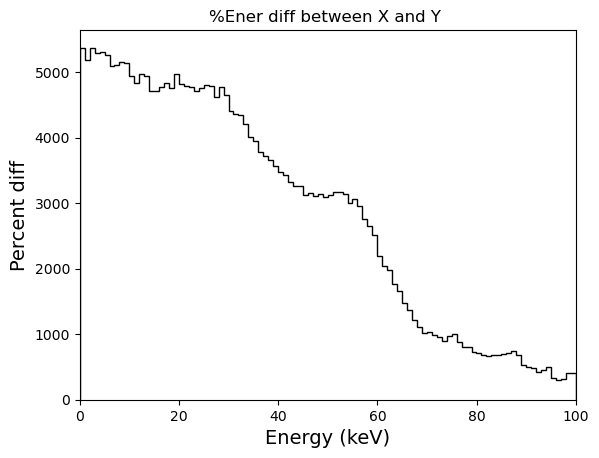

In [59]:
fig, a, b = plt.hist(np.array(delta_list)*100.0, bins=100, label='Delta A1B1',histtype='step', color='black')
plt.xlim(0,100)
#plt.ylim(0,2000)
plt.title('%Ener diff between X and Y ')
plt.xlabel('Energy (keV)', size=14)
plt.ylabel('Percent diff', size=14)
plt.savefig(f"{fpath}ener_diff.jpeg")

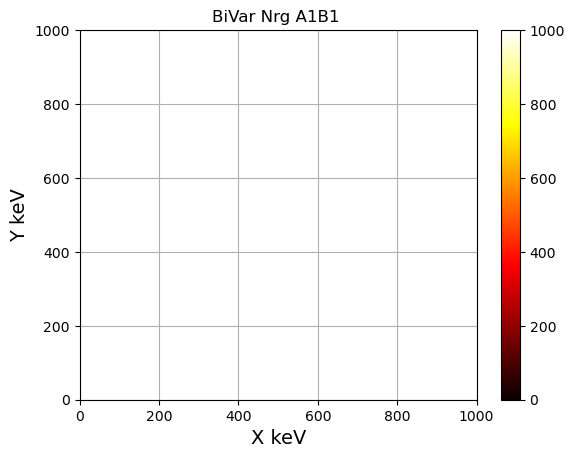

In [60]:
vmax = 1000
#vmax = 20

fig = plt.hist2d(xnrg_list, ynrg_list, bins=(100, 100), cmap='hot', vmax=vmax)
plt.xlim(0,1000.0)
plt.ylim(0,1000.0)
plt.title('BiVar Nrg A1B1 ')
plt.xlabel('X keV', size=14)
plt.ylabel('Y keV', size=14)
plt.grid(axis = 'x')
plt.grid(axis = 'y')
plt.colorbar()
plt.savefig(f"{fpath}bivar_nrg_xy.jpeg")

ValueError: NumPy boolean array indexing assignment cannot assign 0 input values to the 1 output values where the mask is true

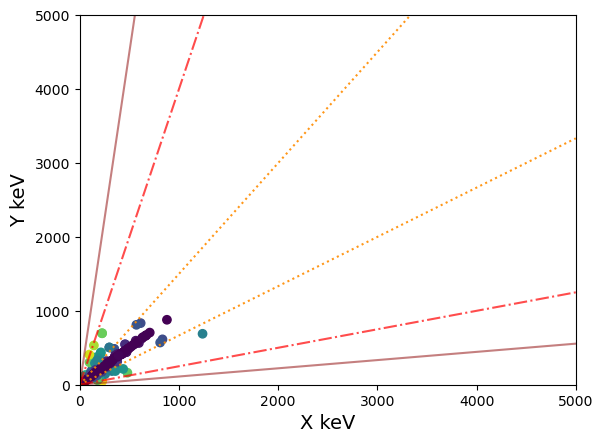

In [135]:
xmax = 5000
ymax = xmax

tot_list = np.array(xnrg_list)+np.array(ynrg_list)
#fig = plt.scatter(xnrg_list, ynrg_list, s = np.array(delta_list)*100.0, c = tot_list, vmax=1000)
fig = plt.scatter(xnrg_list, ynrg_list, c = np.array(delta_list)*100.0)

plt.xlabel('X keV', size=14)
plt.ylabel('Y keV', size=14)
plt.xlim(0,xmax)
plt.ylim(0,ymax)

#CREATING % INDICATORS:
#INDICATOR 1
maxval= xmax#max( max(xnrg_list),max(ynrg_list) )
percent1 = 20/100.0
per1 = maxval*((1-percent1)/(1+percent1))

x1a = per1
y1a = maxval
plt.plot([0.0,x1a], [0, y1a],color="darkorange",linestyle='dotted', label='20%', alpha=0.9)

x1b = maxval
y1b = per1
plt.plot([0.0,x1b], [0, y1b],color="darkorange",linestyle='dotted',label='20%',alpha=0.9)

#CREATING % INDICATORS:
#INDICATOR 2
percent2 = 60/100.0
per2 = maxval*((1-percent2)/(1+percent2))

x2a = per2
y2a = maxval
plt.plot([0.0,x2a], [0, y2a],color="red", linestyle='dashdot', label='60%',alpha=0.7)

x2b = maxval
y2b = per2
plt.plot([0.0,x2b], [0, y2b],color="red",linestyle='dashdot',label='60%', alpha=0.7)


#INDICATOR 3
percent3 = 80/100.0
per3 = maxval*((1-percent3)/(1+percent3))

x3a = per3
y3a = maxval
plt.plot([0.0,x3a], [0, y3a],color="darkred",  label='80%',alpha=0.5)

x3b = maxval
y3b = per3
plt.plot([0.0,x3b], [0, y3b],color="darkred",label='80%', alpha=0.5)

## LINE LABELS
#xvals = [3500,5500,1350,5500,600,5500]
#labelLines( plt.gca().get_lines(), zorder=2.5, align=False, xvals=xvals)
labelLines( plt.gca().get_lines(), zorder=2.5)

plt.title('Bivar Scatter')
plt.colorbar(label='Nrg Diff % (Metric3)')
plt.savefig(f"{fpath}bivar_nrg_scat.jpeg")

In [61]:
fig = plt.hist(np.array(tot_list)/2.0, range=(0,1000), bins=50, histtype='step')
plt.title('Avg Energy Spectra for Bivar 5 MeV B_r1')
plt.xlabel('Energy (keV)', size=14)
plt.ylabel('Counts', size=14)
plt.savefig(f"{fpath}bivar_nrg_spec.jpeg")

NameError: name 'tot_list' is not defined

## Stats

In [62]:
print(f'A1B1        ={cnt_1}')
print(f"A1B1 passed ={cnt_1a}")
print(f'A1B1 failed ={cnt_1-cnt_1a}')

print(f'2Hit         ={cnt_2}')
print(f"A1B2 Hit     ={cnt_2a}")
print(f"A2B1 Hit     ={cnt_2b}")
print(f"A2B2 Hit     ={cnt_2c}")

print('A1B2')
print(f'Neighbor  Chk={cnt_2a_1}')
print(f'Neighbor  Nrg passed ={cnt_2a_1}')
print(f"Added     Chk={cnt_2a_2}")
print(f"Other     Chk={cnt_2a_3}")
print(f"Other Passed ={cnt_2a_3a}")


print('A2B1')
print(f'Neighbor  Chk={cnt_2b_1}')
print(f'Neighbor  Nrg passed ={cnt_2b_1}')
print(f"Added     Chk={cnt_2b_2}")
print(f"Other     Chk={cnt_2b_3}")
print(f"Other Passed ={cnt_2b_3a}")

print('A2B2')
print(f"A2B2 Neighbor  ={cnt_2c_1}")
print(f"A2B2 Neighbor A1B1 ={cnt_2c_1a}")
print(f"A2B2 Neighbor A1B2 ={cnt_2c_1b}")
print(f"A2B2 Neighbor A2B1 ={cnt_2c_1c}")
print(f"A2B2 Neighbor A2B2 ={cnt_2c_1d}")

A1B1        =165397
A1B1 passed =142849
A1B1 failed =22548
2Hit         =155620
A1B2 Hit     =44598
A2B1 Hit     =55430
A2B2 Hit     =55592
A1B2
Neighbor  Chk=34877
Neighbor  Nrg passed =34877
Added     Chk=7819
Other     Chk=777
Other Passed =583
A2B1
Neighbor  Chk=18827
Neighbor  Nrg passed =18827
Added     Chk=15101
Other     Chk=2576
Other Passed =1329
A2B2
A2B2 Neighbor  =0
A2B2 Neighbor A1B1 =7584
A2B2 Neighbor A1B2 =3759
A2B2 Neighbor A2B1 =9568
A2B2 Neighbor A2B2 =40024


In [63]:
print(f'All [{cnt_1}] 1HIT')
print(f"All [{cnt_2}] 2HIT")
print(f"All [{cnt_3}] >2HIT")

print(f"1HIT [{cnt_1}] A1B1")
print(f"A1B1 [{cnt_1a}] VALID")
print(f"A1B1 [{cnt_1+cnt_2c_1a-cnt_1a}] INVALID")

#print(f"Nrg Passed [{cnt_1a}] Valid")
#print(f"Nrg Not Passed [{cnt_1-cnt_1a}] InValid")

print(f"2HIT [{cnt_2a}] A1B2")
print(f"2HIT [{cnt_2b}] A2B1")
print(f"2HIT [{cnt_2c}] A2B2")

# A1B1
print(f"A1B2 [{cnt_2a_1}] NEIGHBOR")
print(f"A1B2 [{cnt_2a_2}] Common A1")
print(f"A1B2 [{cnt_2a_3}] Other")
print(f"Common A1 [{cnt_2a_2}] VALID")
print(f"NEIGHBOR [{cnt_2a_1a}] VALID")
#print(f"A1B1 [{cnt_2a_1a}] VALID")
print(f"NEIGHBOR [{cnt_2a_1-cnt_2a_1a}] INVALID")
print(f"Other [{cnt_2a_3a}] VALID")
print(f"Other [{cnt_2a_3-cnt_2a_3a}] INVALID")


#A2B1
print(f"A2B1 [{cnt_2b_1}] NEIGHBOR")
print(f"A2B1 [{cnt_2b_2}] Common B1")
print(f"A2B1 [{cnt_2b_3}] Other")
print(f"NEIGHBOR [{cnt_2b_1a}] VALID")
print(f"Common B1 [{cnt_2b_2}] VALID")
#print(f"A1B1 [{cnt_2a_1a}] VALID")
print(f"NEIGHBOR [{cnt_2b_1-cnt_2b_1a}] INVALID")
print(f"Other [{cnt_2b_3a}] VALID")
print(f"Other [{cnt_2b_3-cnt_2b_3a}] INVALID")

#A2B2
cnt_2c_1 = cnt_2c_1x+cnt_2c_1y
#print(f"A2B2 [{cnt_2c_1}] A2B2Nbr")
print(f"A2B2 [{cnt_2c_1a}] A1B1")
print(f"A2B2 [{cnt_2c_1b}] A1B2")
print(f"A2B2 [{cnt_2c_1c}] A2B1")
print(f"A2B2 [{cnt_2c_1c}] Lingering")
#print(f"A2B2Nbr [{cnt_2c_1a}] A1B1")
#print(f"A2B2Nbr [{cnt_2c_1b}] A1B2")
#print(f"A2B2Nbr [{cnt_2c_1c}] A2B1")

#print(f"[A2B2-Nbr {cnt_2c_1d}] A2B2-leftover")


All [165397] 1HIT
All [155620] 2HIT
All [62748] >2HIT
1HIT [165397] A1B1
A1B1 [142849] VALID
A1B1 [30132] INVALID
2HIT [44598] A1B2
2HIT [55430] A2B1
2HIT [55592] A2B2
A1B2 [34877] NEIGHBOR
A1B2 [7819] Common A1
A1B2 [777] Other
Common A1 [7819] VALID
NEIGHBOR [0] VALID
NEIGHBOR [34877] INVALID
Other [583] VALID
Other [194] INVALID
A2B1 [18827] NEIGHBOR
A2B1 [15101] Common B1
A2B1 [2576] Other
NEIGHBOR [0] VALID
Common B1 [15101] VALID
NEIGHBOR [18827] INVALID
Other [1329] VALID
Other [1247] INVALID
A2B2 [7584] A1B1
A2B2 [3759] A1B2
A2B2 [9568] A2B1
A2B2 [9568] Lingering


In [64]:
print(f'All [{cnt_1}] A1B1')
print(f"All [{cnt_2}] 2HIT")
print(f"All [{cnt_3}] >2HIT")

print(f"A1B1 [{cnt_1a}] VALID")
print(f"A1B1 [{cnt_1-cnt_1a}] INVALID")

#print(f"Nrg Passed [{cnt_1a}] Valid")
#print(f"Nrg Not Passed [{cnt_1-cnt_1a}] InValid")

print(f"2HIT [{cnt_2a}] A1B2")
print(f"2HIT [{cnt_2b}] A2B1")
print(f"2HIT [{cnt_2c}] A2B2")

# A1B1
print(f"A1B2 [{cnt_2a_1}] NEIGHBOR")
print(f"A1B2 [{cnt_2a_2}] Common A1")
print(f"A1B2 [{cnt_2a_3}] Other")
print(f"Common A1 [{cnt_2a_2}] VALID")
print(f"NEIGHBOR [{cnt_2a_1a}] VALID")
#print(f"A1B1 [{cnt_2a_1a}] VALID")
print(f"NEIGHBOR [{cnt_2a_1-cnt_2a_1a}] INVALID")
print(f"Other [{cnt_2a_3a}] VALID")
print(f"Other [{cnt_2a_3-cnt_2a_3a}] INVALID")


#A2B1
print(f"A2B1 [{cnt_2b_1}] NEIGHBOR")
print(f"A2B1 [{cnt_2b_2}] Common B1")
print(f"A2B1 [{cnt_2b_3}] Other")
print(f"NEIGHBOR [{cnt_2b_1a}] VALID")
print(f"Common B1 [{cnt_2b_2}] VALID")
#print(f"A1B1 [{cnt_2a_1a}] VALID")
print(f"NEIGHBOR [{cnt_2b_1-cnt_2b_1a}] INVALID")
print(f"Other [{cnt_2b_3a}] VALID")
print(f"Other [{cnt_2b_3-cnt_2b_3a}] INVALID")

#A2B2
cnt_2c_1 = cnt_2c_1x+cnt_2c_1y
print(f"A2B2 [{cnt_2c_1}] A2B2Nbr")
print(f"A2B2Nbr [{cnt_2c_1a}] A1B1")
print(f"A2B2Nbr [{cnt_2c_1b}] A1B2")
print(f"A2B2Nbr [{cnt_2c_1c}] A2B1")

All [165397] A1B1
All [155620] 2HIT
All [62748] >2HIT
A1B1 [142849] VALID
A1B1 [22548] INVALID
2HIT [44598] A1B2
2HIT [55430] A2B1
2HIT [55592] A2B2
A1B2 [34877] NEIGHBOR
A1B2 [7819] Common A1
A1B2 [777] Other
Common A1 [7819] VALID
NEIGHBOR [0] VALID
NEIGHBOR [34877] INVALID
Other [583] VALID
Other [194] INVALID
A2B1 [18827] NEIGHBOR
A2B1 [15101] Common B1
A2B1 [2576] Other
NEIGHBOR [0] VALID
Common B1 [15101] VALID
NEIGHBOR [18827] INVALID
Other [1329] VALID
Other [1247] INVALID
A2B2 [28495] A2B2Nbr
A2B2Nbr [7584] A1B1
A2B2Nbr [3759] A1B2
A2B2Nbr [9568] A2B1


In [ ]:
def two_hit_func(evt):
    
    global cnt_2a
    global cnt_2b
    global cnt_2c
    
    global cnt_2a_1
    global cnt_2a_1a
    
    global cnt_2a_2
    
    # This should return 
    x_cnt = np.count_nonzero(evt[0,:]>0.0)
    y_cnt = np.count_nonzero(evt[1,:]>0.0)
    
    xloc = np.where(evt[0,:] > 0)[0]
    yloc = np.where(evt[1,:] > 0)[0]
    
    #this has output as 1,1 or 1,2
    if (x_cnt == 1) and (y_cnt == 2):
        cnt_2a += 1
        print(yloc[0],yloc[1])
        if (chk_neighbor(yloc[0],yloc[1])): 
            cnt_2a_1 += 1
            
            # need to add energy and check if its close.
            #avg_ypos(yloc[0],yloc[1]) 
            new_nrg = add_nrg(evt[1,yloc[0]], evt[1,yloc[1]])
            print(new_nrg,evt[1,yloc[0]], evt[1,yloc[1]])
            
            # neighbor so now its 1,1
            #check nrg.
            print("Test1")
            new_avg_nrg= check_nrg_onehit(evt[0,xloc[0]], new_nrg)
            
            if new_avg_nrg is not None :
                cnt_2a_1a += 1
                xpos = xtab[xloc]
                ypos = avg_ypos(yloc[0],yloc[1]) 
                zpos = ztab[layer]
                return (xpos, ypos, zpos, new_avg_nrg)
            else:
                return None
        else:
            #non neighbor so check 2 energy hit with 1 energy.
            #check if both added is close to 1.
            #else if check which one is the closest.
            xnrg1 = evt[0,xloc[0]]
            ynrg1 = evt[1,yloc[0]]
            ynrg2 = evt[1,yloc[1]]
           
            diff1 = abs(xnrg1-ynrg1)
            diff2 = abs(xnrg1-ynrg2)

            if (diff1 < diff2):
                avg_nrg = (check_nrg_onehit(xnrg1,ynrg1))
                if avg_nrg is not None:
                    cnt_2a_2 += 1
                    pos = position_func(xloc[0],yloc[0],layer)
                    return (pos[0], pos[1], pos[2], avg_nrg)
                else:
                    return None
            else:
                avg_nrg = (check_nrg_onehit(xnrg1,ynrg2))
                if avg_nrg is not None:
                    cnt_2a_2 += 1
                    pos = position_func(xloc[0],yloc[1],layer)
                    return (pos[0], pos[1], pos[2], avg_nrg)
                else:
                    return None    

    elif (x_cnt == 2) and (y_cnt == 1):
        cnt_2b += 1
        print(xloc[0],xloc[1])
        if (chk_neighbor(xloc[0],xloc[1])):
            avg_xpos(xloc[0],xloc[1])
    
    elif (x_cnt == 2) and (y_cnt == 2):    
        cnt_2c += 1
        print(xloc[0],xloc[1],yloc[0],yloc[1])
        print('2x2y')
        
    else:
        print('What')
           
    return 100.00

# Tests

In [ ]:
file['layer00/vdata'].keys()

In [ ]:
file['layer00/vdata/calib_data']

In [ ]:
file['layer00/vdata/nrg']

## array

In [ ]:
a = [[1.0, 2.0, 3.0, 4.0]]

In [ ]:
[xpos_val, ypos_val, zpos_val, nrg_val] = a[0]

In [ ]:
xpos_val

In [ ]:
len(a), type(a)

In [ ]:
b = [[1.0, 2.0, 3.0, 4.0],[1.0, 6.0, 3.0, 4.0],[2.0, 3.0, 6.0, 3.0],[3.0, 1.0, 6.0, 5.0],[4.0, 4.0, 4.0, 4.0],
     [5.0, 5.0, 5.0, 5.0],[5.0, 2.0, 5.0, 4.0],[6.0, 6.0, 6.0, 6.0],[0.0, 0.0, 5.0, 4.0],[2.0, 2.0, 2.0, 2.0]]

In [ ]:
len(b), type(b)

In [ ]:
barr = np.array(b)
barr

In [ ]:
c = np.sort(b, axis=-1)
c

In [ ]:
c1 =barr[barr[:,0].argsort()]
c1

In [ ]:
a = [[2, 3, 6, 10, 20,],[ 2, 5, 30, 14, 12,]]
a = np.array(a)

In [ ]:
b = a>4
b

## Math

### relative change

In [ ]:
a = 1000
b = 1000
print(f"a={a}, b={b}")
print(f"1) diff/max :{abs(a-b)/max(a,b)}")
print(f"2) diff/sum :{abs(a-b)/(a+b)}")
print(f"3) diff/mean :{abs(a-b)/((a+b)/2)}")

In [ ]:
#max and min..

In [ ]:
6000*2/3